<h1 style="text-align:center; color:blue">Model Comparison</h1> 

In [33]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
import xgboost as xgb
import sklearn
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

We are going to compare 4 models with the cleaned data and the filtered data with and without duration in order to compare the efectiveness of the processing and the models. Each model will have its own way to handle the unbalanced dataset since we have considered it the best for each model.

# Models function

In [21]:
def model_metrics(model, X_train, y_train, X_test, y_test, predictions):
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    (tn, fp, fn, tp) = confusion_matrix(y_train, model.predict(X_train)).ravel()
    print(tn, fp, fn, tp)
    (tn, fp, fn, tp) = confusion_matrix(y_test, predictions).ravel()
    print(tn, fp, fn, tp)
    
    return accuracy, f1

In [36]:
def xgboost_model(data_s):
    X = data_s.loc[:, data_s.columns!= 'y_yes']
    y = data_s.loc[:, 'y_yes']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imbalance_rate = y.value_counts()[0]/y.value_counts()[1]
    scores_list = []
    metric = 'f1'
    weight_array = np.arange(imbalance_rate - 7.5, imbalance_rate + 4.1, 0.5)
    for weight in weight_array:
        model = xgb.XGBClassifier(scale_pos_weight=weight)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
        # print(f'Mean {metric}: %.5f' % np.mean(scores))
        scores_list.append(np.mean(scores))
    model = xgb.XGBClassifier(scale_pos_weight=weight_array[np.argmax(scores_list)])
    model.fit(X_train, y_train.astype(int))
    xgb.plot_importance(model)
    plt.show()
    predictions = model.predict(X_test)
    
    accuracy, f1 = model_metrics(model, X_train, y_train, X_test, y_test, predictions)
    
    return accuracy, f1

In [37]:
def bagging_model(data_s):
    X = data_s.loc[:, data_s.columns!= 'y_yes']
    y = data_s.loc[:, 'y_yes']
    
    rus = RandomUnderSampler(sampling_strategy=1)
    X_res, y_res = rus.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res)
    
    model = BaggingClassifier(base_estimator=SVC())
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    accuracy, f1 = model_metrics(model, X_train, y_train, X_test, y_test, prediction)
    
    return accuracy, f1

Since in the lr is better to have the data centered in 0 in order to maximize its fit and we know our scaled data is from 0 to 1, we'll substract 0.5 to our data for logistic regression.

In [38]:
def lr_model(data_s):
    X = data_s.loc[:, data_s.columns!= 'y_yes'] - 0.5
    y = data_s.loc[:, 'y_yes']
    
    rus = RandomUnderSampler(sampling_strategy=1)
    X_res, y_res = rus.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)
    
    logModel = LogisticRegression()
    logModel.fit(X_train, y_train)
    
    prediction = logModel.predict(X_test)
    
    accuracy, f1 = model_metrics(logModel, X_train, y_train, X_test, y_test, prediction)
    
    return accuracy, f1

The decision tree doesn't need the data scaled because of how is constructed. However, we need to handle with the unbalanced dataset.

In [39]:
def post_prune(x_train, y_train):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(x_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    train_acc = []
    max_f1_score = 0
    best_c = 0
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(x_train, y_train)
        y_train_pred = clf.predict(x_train)
        f1 = f1_score(y_train_pred, y_train)
        if f1 > max_f1_score:
            max_f1_score = f1
            best_c = ccp_alpha        
    return best_c

In [40]:
def dt_model(data):
    X = data.loc[:, data.columns!= 'y_yes']
    y = data.loc[:, 'y_yes']
    
    rus = RandomUnderSampler(sampling_strategy=1)
    X_res, y_res = rus.fit_resample(X, y)
    
    x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)
    
    c = post_prune(x_train, y_train)
    print(c)
    
    metric = 'f1'
    
    params = {'max_depth': list(range(2, 10, 2)),
              'min_samples_split': list(range(2, 4)),
              'min_samples_leaf': [1, 2]}

    clf = DecisionTreeClassifier(ccp_alpha=c)
    gcv = GridSearchCV(estimator=clf, param_grid=params, scoring=metric)
    gcv.fit(x_train, y_train)
    
    dt = gcv.best_estimator_
    dt.fit(x_train,y_train)
    
    prediction = dt.predict(x_test)
    
    accuracy, f1 = model_metrics(dt, x_train, y_train, x_test, y_test, prediction)
    
    return accuracy, f1

In [41]:
model_list = [xgboost_model, bagging_model, lr_model, dt_model]
model_names = ['xgboost', 'bagging', 'LogisticRegression', 'DecisionTree']

# Getting all data

In [42]:
data_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/cleaned_data.csv", sep=",")
data_s_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/cleaned_data_scaled.csv", sep=",")

data = data_dur.drop('duration', axis=1)
data_s = data_s_dur.drop('duration', axis=1)

In [60]:
filtered_data_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data_dur.csv", sep=",")
filtered_data_s_dur = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/filtered_data_scaled_dur.csv", sep=",")

filtered_data = data_dur.drop('duration', axis=1)
filtered_data_s = data_s_dur.drop('duration', axis=1)

# Running models

## Cleaned data without duration

------------------------------xgboost------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
28242 1425 960 2323
6897 519 372 450
------------------------------bagging------------------------------
2905 379 1032 2252
698 123 246 575
------------------------------LogisticRegression------------------------------
2830 476 1069 2193
680 119 255 588
------------------------------DecisionTree------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5.075111652456355e-05
2954 310 1120 2184
756 85 285 516


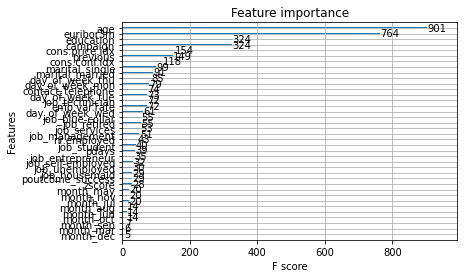

In [45]:
results = []

for i in range(len(model_list)):
    model_name = model_names[i]
    print(f"------------------------------{model_name}------------------------------")
    fun_model = model_list[i]
    if model_name != 'DecisionTree':
        results.append(fun_model(data_s))
    else:
        results.append(fun_model(data))

## Cleaned data with duration

------------------------------xgboost------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
28278 1389 172 3111
6816 600 213 609
------------------------------bagging------------------------------
2809 475 242 3042
699 122 71 750
------------------------------LogisticRegression------------------------------
2801 472 400 2895
716 116 106 704
------------------------------DecisionTree------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0
2763 529 210 3066
664 149 55 774


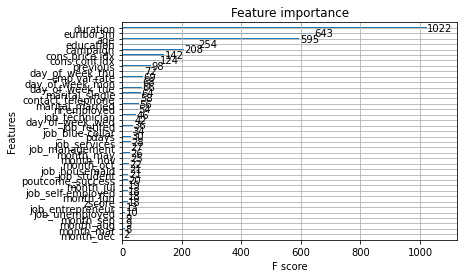

In [47]:
results_dur = []

for i in range(len(model_list)):
    model_name = model_names[i]
    print(f"------------------------------{model_name}------------------------------")
    fun_model = model_list[i]
    if model_name != 'DecisionTree':
        results_dur.append(fun_model(data_s_dur))
    else:
        results_dur.append(fun_model(data_dur))

## Filtered data without duration

------------------------------xgboost------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
28242 1425 960 2323
6897 519 372 450
------------------------------bagging------------------------------
2819 465 956 2328
694 127 235 586
------------------------------LogisticRegression------------------------------
2761 502 1038 2267
689 153 259 541
------------------------------DecisionTree------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5.075111652456355e-05
3000 289 1112 2167
732 84 316 510


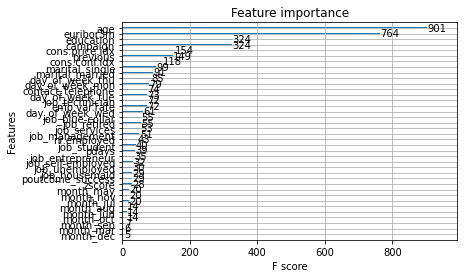

In [48]:
filtered_results = []

for i in range(len(model_list)):
    model_name = model_names[i]
    print(f"------------------------------{model_name}------------------------------")
    fun_model = model_list[i]
    if model_name != 'DecisionTree':
        filtered_results.append(fun_model(filtered_data_s))
    else:
        filtered_results.append(fun_model(filtered_data))

## Filtered data with duration

------------------------------xgboost------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
27950 1717 209 3074
6770 646 192 630
------------------------------bagging------------------------------
2752 532 276 3008
689 132 73 748
------------------------------LogisticRegression------------------------------
2758 519 462 2829
683 145 112 702
------------------------------DecisionTree------------------------------


c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0
2762 508 215 3083
678 157 73 734


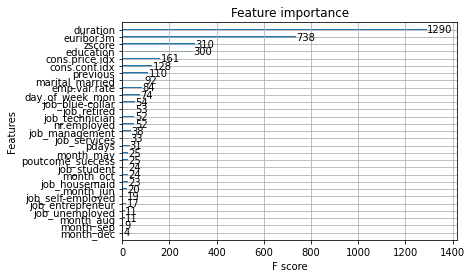

In [63]:
filtered_results_dur = []

for i in range(len(model_list)):
    model_name = model_names[i]
    print(f"------------------------------{model_name}------------------------------")
    fun_model = model_list[i]
    if model_name != 'DecisionTree':
        filtered_results_dur.append(fun_model(filtered_data_s_dur))
    else:
        filtered_results_dur.append(fun_model(filtered_data_dur))

## All results

In [64]:
pd.DataFrame(results, columns=['acc', 'f1'], index=model_names)

,acc,f1
xgboost,0.891843,0.502513
bagging,0.775274,0.757077
LogisticRegression,0.772229,0.758710
DecisionTree,0.774665,0.736091


In [65]:
pd.DataFrame(results_dur, columns=['acc', 'f1'], index=model_names)

,acc,f1
xgboost,0.901311,0.599705
bagging,0.882460,0.886001
LogisticRegression,0.864799,0.863804
DecisionTree,0.875761,0.883562


In [66]:
pd.DataFrame(filtered_results, columns=['acc', 'f1'], index=model_names)

,acc,f1
xgboost,0.891843,0.502513
bagging,0.779537,0.764016
LogisticRegression,0.749086,0.724230
DecisionTree,0.756395,0.718310


In [67]:
pd.DataFrame(filtered_results_dur, columns=['acc', 'f1'], index=model_names)

,acc,f1
xgboost,0.898276,0.600572
bagging,0.875152,0.879483
LogisticRegression,0.843484,0.845274
DecisionTree,0.859927,0.864547


As we can see, the models are much better with the duration column. Also, it seems like the undersampling goes better in terms of f1, but slighly worse with accuracy. Apart from that, all the models are better than choosing randomly. 

The filter can be avoided since it doesn't improve the results.

Taking account all this, we will choose the logistic regression as our model, since it is the simpliest one without loosing significantly in any of the chosen metrics.